# Load Annan LGM data
- update 5/10/23 to load Pliocene data

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point
import seaborn as sns

In [39]:
# tarea = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'cicefsdww3i.cice.h1.0086.nc').tarea
landfrac = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

In [69]:
## load Annan data : LGM
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/annan/'
annan_ens = xr.open_dataset(path + 'SST.all.lgm.nc').rename({'SST.all':'sst'})
annan_mean = xr.open_dataset(path + 'SST.mean.lgm.nc').rename({'SST.mean':'sst'})
annan_mean['longitude'] = np.sort(annan_mean.longitude)-180
annan_ens['longitude'] = annan_mean.longitude

In [54]:
## load Annan data : Pliocene
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/annan/pliocene/'
plio_ens = xr.open_dataset(path + 'SST.all.plio.nc').rename({'SST.all':'sst'})
plio_mean = xr.open_dataset(path + 'SST.mean.plio.nc').rename({'SST.mean':'sst'})
plio_sd = xr.open_dataset(path + 'SST.sd.plio.nc').rename({'SST.sd':'sst'})
plio_mean['longitude'] = np.sort(plio_mean.longitude)-180
plio_ens['longitude'] = plio_mean.longitude
plio_sd['longitude'] = plio_mean.longitude

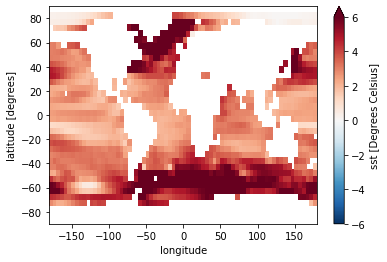

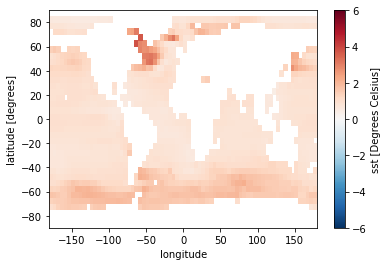

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


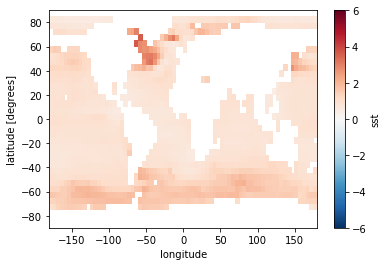

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


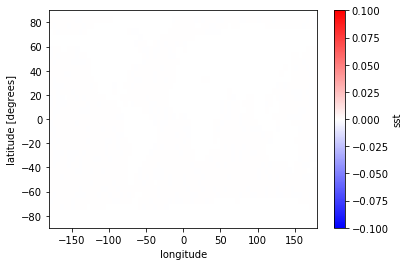

In [62]:
plio_mean.sst.plot(cmap='RdBu_r',vmin=-6,vmax=6)
plt.show()

plio_sd.sst.plot(cmap='RdBu_r',vmin=-6,vmax=6)
plt.show()

plio_ens.sst.std(dim='model').plot(cmap='RdBu_r',vmin=-6,vmax=6)
plt.show()

(plio_ens.sst.std(dim='model',ddof=1) - plio_sd.sst).plot(cmap='bwr',vmin=-0.1,vmax=.1)
# (plio_ens.sst.std(dim='model',ddof=0) - plio_sd.sst).plot(cmap='bwr',vmin=-0.1,vmax=.1)
plt.show()

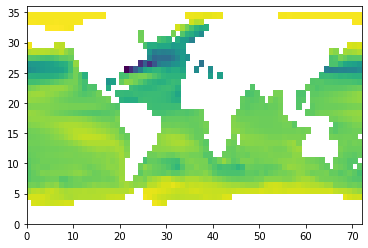

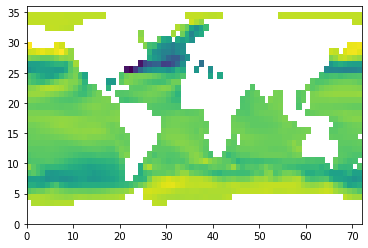

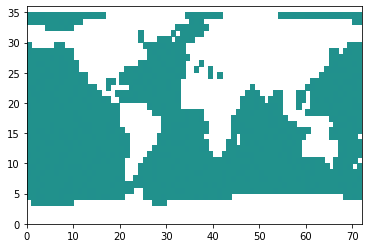

In [4]:
plt.pcolormesh(annan_mean.sst.values)
plt.show()

plt.pcolormesh(annan_ens.sst[0].values)
plt.show()

plt.pcolormesh(annan_ens.sst.mean(axis=0).values - annan_mean.sst.values,vmin=-0.001,vmax=0.001)
plt.show()

In [5]:
np.allclose(annan_ens.sst.mean(axis=0).values, annan_mean.sst.values,equal_nan=True)

True

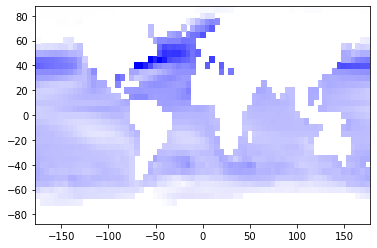

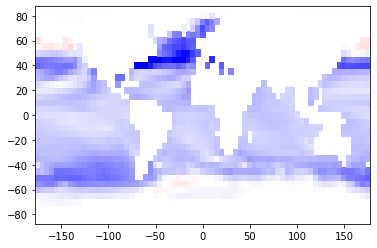

In [6]:
plt.pcolormesh(annan_mean.longitude, annan_mean.latitude, annan_mean.sst,cmap='bwr',vmin=-8,vmax=8)
plt.show()
plt.pcolormesh(annan_ens.longitude, annan_ens.latitude, annan_ens.sst[0],cmap='bwr',vmin=-8,vmax=8)
plt.show()

# plt.pcolormesh(annan_mean.longitude, annan_mean.latitude, annan_mean.sst,cmap='bwr',vmin=-8,vmax=8)
# plt.show()
# plt.pcolormesh(annan_ens.longitude, annan_ens.latitude, annan_ens.sst[0],cmap='bwr',vmin=-8,vmax=8)
# plt.show()

In [7]:
annan_mean.longitude

<xarray.DataArray 'longitude' (longitude: 72)>
array([-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5, -137.5,
       -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5,  -97.5,  -92.5,
        -87.5,  -82.5,  -77.5,  -72.5,  -67.5,  -62.5,  -57.5,  -52.5,  -47.5,
        -42.5,  -37.5,  -32.5,  -27.5,  -22.5,  -17.5,  -12.5,   -7.5,   -2.5,
          2.5,    7.5,   12.5,   17.5,   22.5,   27.5,   32.5,   37.5,   42.5,
         47.5,   52.5,   57.5,   62.5,   67.5,   72.5,   77.5,   82.5,   87.5,
         92.5,   97.5,  102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,
        137.5,  142.5,  147.5,  152.5,  157.5,  162.5,  167.5,  172.5,  177.5])
Coordinates:
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5

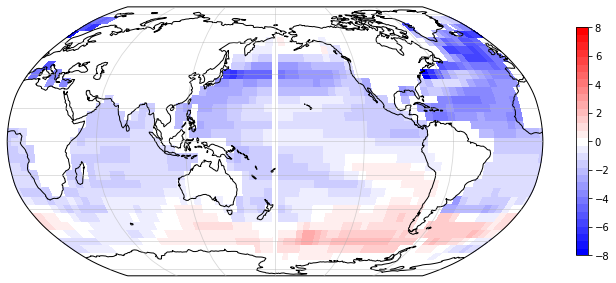

In [8]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ens.sst[1]
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.longitude, ds.latitude, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

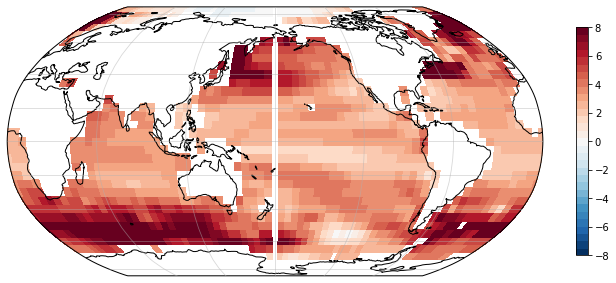

In [64]:
## Pliocene
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = plio_ens.sst[1]
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.longitude, ds.latitude, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

In [37]:
# annan_ens_save = annan_ens.rename({'longitude':'lon','latitude':'lat'})
# annan_ens_save.to_netcdf('/home/disk/atmos/vcooper/work/p2c2/lgm/annan/annan_ens.nc')

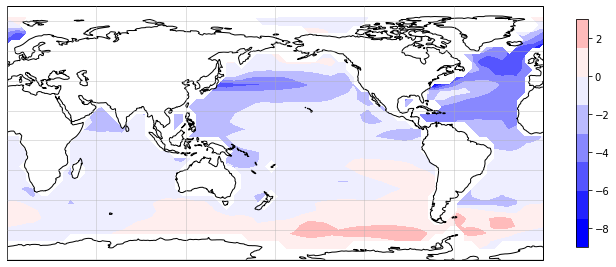

In [34]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ens.sst[1]
# add cyclic point
lon_idx = ds.dims.index('longitude')
lon = ds.coords['longitude']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.latitude, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.latitude, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

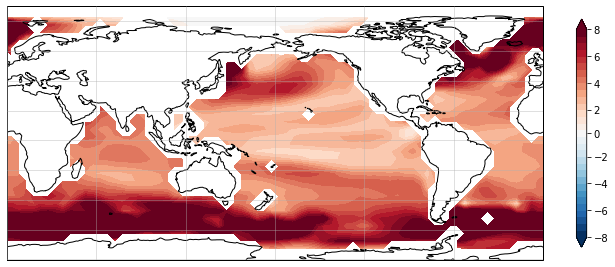

In [66]:
## checking the anomaly pattern before infill
## Pliocene
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = plio_ens.sst[-1]
# add cyclic point
lon_idx = ds.dims.index('longitude')
lon = ds.coords['longitude']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.latitude, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.latitude, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

## fix issue with lat lons by regridding

In [70]:
#############
### Preprocessing ###
## Load SST from other datasets

ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'

# dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = tempds.set_coords(['lat','lon','month'])
# # tempds = xr.merge([tempds.set_coords(['lat','lon','month','ens']).sst,
# #                    tempds.set_coords(['lat','lon','month','ens']).ens])
# holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = tempds.set_coords(['lat','lon','month'])
# lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

# ## Load ICEFRAC
dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
# lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

In [80]:
################
# xesmf regridding 
newgrid = holo_ice_climo # desired grid
# data_for_regridding = lgm_sst_climo

plio_ens['mask'] = xr.where(np.isnan(plio_ens.sst[0]), 0, 1)
data_for_regridding = plio_ens

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
#                          filename='bilinear_margo_to_holo_per_extrapID.nc',
                         reuse_weights=False)

# lgm_sst_climo_hologrid_extrap = regridder(lgm_sst_climo)
plio_ens_extrap = regridder(plio_ens)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.DataArray 'sst' (latitude: 36, longitude: 72)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.390275, -0.325732, -0.320957, ..., -0.616854, -0.551018, -0.462841],
       [-0.133557, -0.108852, -0.078949, ..., -0.25163 , -0.210618, -0.172397],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * latitude   (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
    model      int32 1
Attributes:
    units:    Degrees Celsius

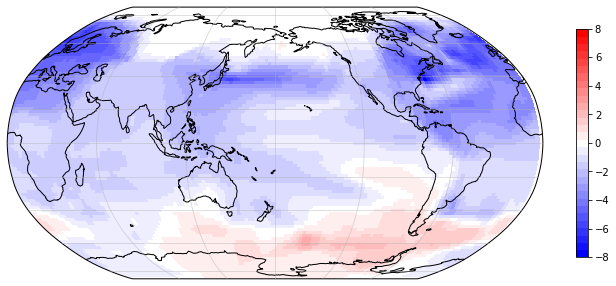

In [29]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = lgm_sst_climo_hologrid_extrap.sst[1]
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.lon, ds.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
# axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

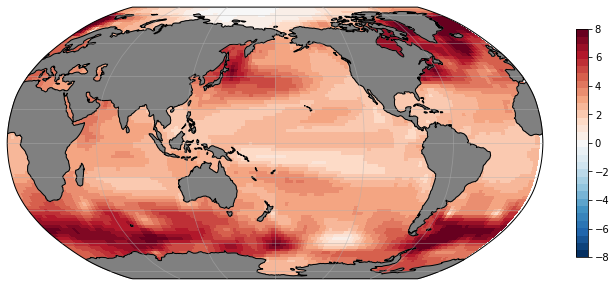

In [82]:
## checking the anomaly pattern before infill
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = plio_ens_extrap.sst.mean(dim='model')
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(ds.lon, ds.lat, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.lon, ds.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

## Quick test Green's functions

In [83]:
green = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/ref_files/CAM4-CAM5_Greens_Function.nc')

In [132]:
## LH baseline
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'LGMRholo_bc_final_prediddle_v3.nc'
baseline_v3 = xr.open_dataset(savepath + fname).SST_cpl_prediddle.mean(dim='time')

In [133]:
## LRMIP
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'lrmip-seas_bc_final_prediddle_v2.nc'
lrmipseas_bc_final_prediddle = xr.open_dataset(savepath + fname)

lrmip = lrmipseas_bc_final_prediddle.SST_cpl_prediddle.mean(dim='time') - baseline_v3

In [134]:
## LGM for comparison

## Ensemble members
fname = 'LGMRlgm05th_bc_final_prediddle_v3.nc'
LGMRlgm05th_bc_final_prediddle_v3 = xr.open_dataset(
    savepath + fname).SST_cpl_prediddle.mean(dim='time') - baseline_v3

fname = 'LGMRlgm95th_bc_final_prediddle_v3.nc'
LGMRlgm95th_bc_final_prediddle_v3 = xr.open_dataset(
    savepath + fname).SST_cpl_prediddle.mean(dim='time') - baseline_v3

fname = 'LGMRlgm1q_bc_final_prediddle_v3.nc'
LGMRlgm1q_bc_final_prediddle_v3 = xr.open_dataset(
    savepath + fname).SST_cpl_prediddle.mean(dim='time') - baseline_v3

fname = 'LGMRlgm4q_bc_final_prediddle_v3.nc'
LGMRlgm4q_bc_final_prediddle_v3 = xr.open_dataset(
    savepath + fname).SST_cpl_prediddle.mean(dim='time') - baseline_v3

## annan LGM
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan-seas_bc_final_prediddle_v2.1.nc'
annanseas_bc_final_prediddle = xr.open_dataset(
    savepath + fname).SST_cpl_prediddle.mean(dim='time') - baseline_v3

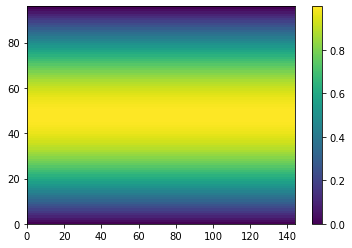

In [135]:
_,llat = np.meshgrid(lrmip.lon,lrmip.lat)
coswts = np.cos(np.deg2rad(llat))
plt.pcolormesh(coswts)
plt.colorbar()
coswts = coswts / coswts.sum()

In [136]:
lrmip_cam5lamb = (lrmip * green.TOA_CAM5.values).sum() / (lrmip * green.TAS_CAM5.values).sum()
lrmip_cam4lamb = (lrmip * green.TOA_CAM4.values).sum() / (lrmip * green.TAS_CAM4.values).sum()

print(lrmip_cam5lamb.values)
print(lrmip_cam4lamb.values)

-1.5465146170504378
-2.128028074641127


In [137]:
plio_cam5lamb = (plio_ens_extrap.sst.mean(dim='model') * green.TOA_CAM5.values).sum() / (
    plio_ens_extrap.sst.mean(dim='model') * green.TAS_CAM5.values).sum()

plio_cam4lamb = (plio_ens_extrap.sst.mean(dim='model') * green.TOA_CAM4.values).sum() / (
    plio_ens_extrap.sst.mean(dim='model') * green.TAS_CAM4.values).sum()

print(plio_cam5lamb.values)
print(plio_cam4lamb.values)

-1.2992676817318798
-1.3944378766836385


In [138]:
def plio_gf5(sstfile):
    lamb = (sstfile * green.TOA_CAM5.values).sum() / (
            sstfile * green.TAS_CAM5.values).sum()
    return(float(lamb.values))
    
def plio_gf4(sstfile):
    lamb = (sstfile * green.TOA_CAM4.values).sum() / (
            sstfile * green.TAS_CAM4.values).sum()
    return(float(lamb.values))

In [139]:
plio_4lamb_ens = np.array([plio_gf4(sst_e) for i,sst_e in enumerate(plio_ens_extrap.sst)])
plio_5lamb_ens = np.array([plio_gf5(sst_e) for i,sst_e in enumerate(plio_ens_extrap.sst)])

In [144]:
plt.hist?

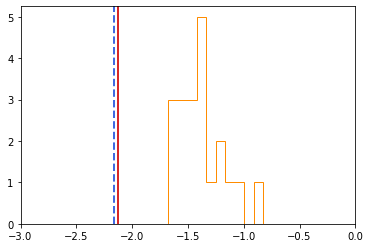

In [152]:
plt.hist(plio_4lamb_ens,bins=10,color='darkorange',histtype='step')

plt.axvline(lrmip_cam4lamb,c='tab:red',lw=2)
plt.axvline(plio_gf4(annanseas_bc_final_prediddle), c='royalblue', lw=2,ls='--')
plt.xlim(-3,0)
plt.show()

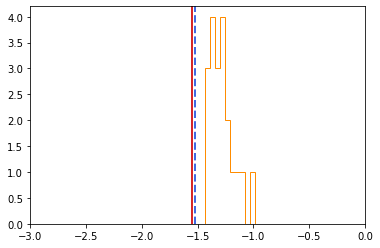

In [153]:
plt.hist(plio_5lamb_ens,bins=10,color='darkorange',histtype='step')

plt.axvline(lrmip_cam5lamb,c='tab:red',lw=2)
plt.axvline(plio_gf5(annanseas_bc_final_prediddle), c='royalblue', lw=2, ls='--')

plt.xlim(-3,0)
plt.show()